In [1]:
import numpy as np
import matplotlib.pyplot as plt
import functools
import operator
import math

gdk:  1000 (2, 2) 2 2


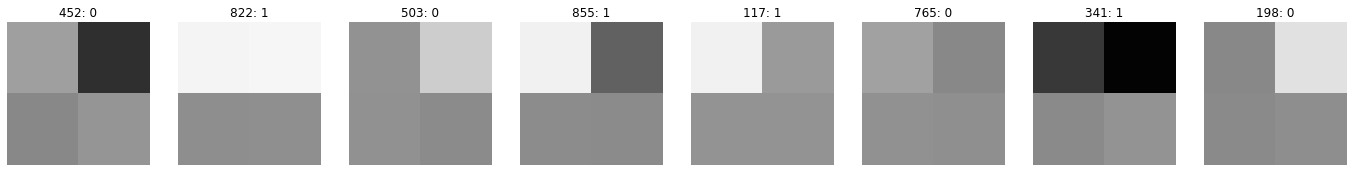

In [20]:
def show(data, labels=None, s=8):
    n, c, j = data.shape[0], data.shape[-1], 1
    labels = [None] * data.shape[0] if labels is None else labels
    plt.figure(figsize=(3 * s, 3))
    for i in np.random.randint(0, n, s):
        plt.subplot(1, s, j)
        plt.imshow(data[i], cmap="Greys", vmin=0, vmax=1)
        plt.title(str(i) + ": " + str(labels[i]))
        plt.axis("off")
        j += 1
    plt.show()

def gdk(n=1000, d=(2, 2), k=2, c=2, **kwargs):
    pd = functools.reduce(operator.mul, d, 1)
    assert(k <= pd)
    data = np.ones((n, *d))

    mask = np.arange(0, pd).reshape(d) < k
    common = np.ones((n, *d)) * 0.5
    random = np.random.random((n, *d))
    data = np.where(mask, random, common + 0.05 * random)
    labels = np.array([
        int((math.sin(d.flatten()[0] * 10) + 1) / 2 * c)
        for d in data])

    print("gdk: ", n, d, k, c)
    show(data, labels, **kwargs)
    return data, labels

gdk();

gdk:  16384 (1, 3) 2 2


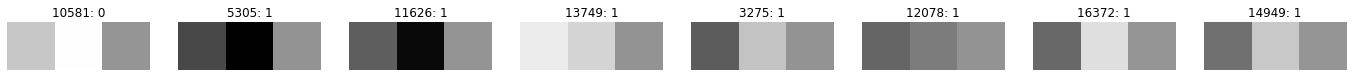

gdk:  2048 (1, 3) 2 2


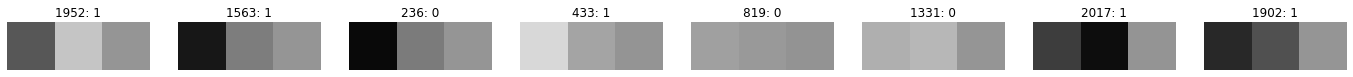

loss 312.81057584041014
epoch 1 nerr 0.3583984375
loss 249.8247198004407
epoch 2 nerr 0.1630859375
loss 191.4957138617628
epoch 3 nerr 0.08740234375
loss 159.88962805711438
epoch 4 nerr 0.07177734375
loss 133.0525252409651
epoch 5 nerr 0.06103515625
loss 110.36859584290772
epoch 6 nerr 0.06103515625
loss 93.80256925918815
epoch 7 nerr 0.0322265625
loss 81.95288890408864
epoch 8 nerr 0.02197265625
loss 73.29050951894507
epoch 9 nerr 0.017578125
loss 66.7625835093335
epoch 10 nerr 0.01123046875
loss 61.68183253154528
epoch 11 nerr 0.0068359375
loss 57.60055213214604
epoch 12 nerr 0.005859375
loss 54.22733950991648
epoch 13 nerr 0.00732421875
loss 51.38040246270695
epoch 14 nerr 0.00830078125
loss 48.94608434562978
epoch 15 nerr 0.00732421875
loss 46.827522796707385
epoch 16 nerr 0.0068359375
loss 44.96386033053278
epoch 17 nerr 0.0078125
loss 43.30656850836976
epoch 18 nerr 0.00830078125
loss 41.80499553820249
epoch 19 nerr 0.00830078125
loss 40.43306616347027
epoch 20 nerr 0.00830078125

In [19]:
import jax
from jax.experimental import stax, optimizers
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
key = jax.random.PRNGKey(0)

ns, d, k, c, batch = (16384, 2048), (1, 3), 2, 2, 512
trainx, trainy, testx, testy = \
    *gdk(ns[0], d, k, c), *gdk(ns[1], d, k, c)
init_fun, model = jax.experimental.stax.serial(
    jax.experimental.stax.Flatten,
    jax.experimental.stax.Dense(16),
    jax.experimental.stax.Relu,
    jax.experimental.stax.Dense(16),
    jax.experimental.stax.Relu,
    jax.experimental.stax.Dense(c),
    jax.experimental.stax.LogSoftmax)
_, params = init_fun(key, (batch, *d))
opt_init, opt_update, get_params = \
    jax.experimental.optimizers.adam(0.003)
opt_state = opt_init(params)

def meval(model, params, xs, ys):
    correct = 0
    for step in range(len(xs) // batch):
        x, y = xs[step * batch:(step + 1) * batch], \
            ys[step * batch:(step + 1) * batch]
        pred = np.argmax(model(params, x), axis=1)
        correct += np.sum(pred == y)
    return correct / len(xs)

for epoch in range(30):
    for step in range(ns[0] // batch):
        x, y = trainx[step * batch:(step + 1) * batch], \
            trainy[step * batch:(step + 1) * batch]
        loss, grads = jax.value_and_grad(
            lambda params, xs, ys: -np.sum(model(params, xs) *
            np.array([[1 if i == label else 0
                for i in range(c)]
                for label in ys])) # adaptor for softmax out
        )(params, x, y)
        print("\rloss", loss, end="")
        opt_state = opt_update(0, grads, opt_state)
        params = get_params(opt_state)
    print("\nepoch", epoch + 1, "nerr", 1 - meval(model, params, testx, testy))

In [27]:
import adversarial_ntks
from adversarial_ntks import attacks
pertxs = []
for step in range(len(testx) // batch):
    x, y = testx[step * batch:(step + 1) * batch], \
        testy[step * batch:(step + 1) * batch]
    pertx = adversarial_ntks.attacks.pgd(x, y,
        lambda X: np.random.random((batch, 3)),
        0.08, 2, 15, 0.005, 2, True)
    pred = np.argmax(model(params, x), axis=1)
    print(np.sum(pred == y))

ValueError: non-broadcastable output operand with shape (512,1,3) doesn't match the broadcast shape (512,512,3)